## Topic Classification with Log Probs

This notebook explores the use of log probabilities (logprobs) for multi-label topic classification. We will generate a synthetic dataset of texts, each associated with one or more topics. Then, we'll use different models from Ollama and OpenAI to classify these texts and analyze how different probability thresholds impact the accuracy of the topic assignments. The goal is to find an optimal threshold for each model and compare their performance.

In [5]:
import requests
import json
import math
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import dotenv
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

### 1. Generate Synthetic Dataset

In [6]:
topics = [
    'Technology', 'Sports', 'Politics', 'Art', 'Science', 
    'Health', 'Education', 'Travel', 'Food', 'History'
]

def generate_text_for_topics(topics_list):
    url = 'http://localhost:11434/api/generate'
    prompt = f"Generate a short, single sentence about {' and '.join(topics_list)}. Do not mention the topic names."
    payload = {
        'model': 'dolphin-mistral',
        'prompt': prompt,
        'stream': False
    }
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        return response.json()['response'].strip()
    except requests.exceptions.RequestException as e:
        print(f'Error generating text: {e}')
        return 'Error generating text.'

dataset = []
if os.path.exists('synthetic_dataset.csv'):
    df = pd.read_csv('synthetic_dataset.csv')
    df['topics'] = df['topics'].apply(lambda x: eval(x))
else:
    for _ in tqdm(range(100), desc='Generating dataset'):
        num_topics = np.random.randint(1, 4)
        assigned_topics = np.random.choice(topics, num_topics, replace=False).tolist()
        text = generate_text_for_topics(assigned_topics)
        dataset.append({'text': text, 'topics': assigned_topics})
    df = pd.DataFrame(dataset)
    df.to_csv('synthetic_dataset.csv', index=False)

df.head()

Generating dataset: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


,text,topics
0,The dynamic interplay between science and tech...,"[Science, Technology, Politics]"
1,Art is the harmonious combination of human emo...,[Art]
2,The interplay between creativity and innovatio...,"[Science, Art, Food]"
3,Balanced diets significantly impact student at...,"[Education, Food]"
4,"During a recent trip, I discovered how the pri...","[Sports, Travel, Science]"


In [7]:
df.sample(10)

,text,topics
2,The interplay between creativity and innovatio...,"[Science, Art, Food]"
10,The acquisition of knowledge in different cont...,"[Education, History, Travel]"
54,"""The fusion of sports education and technology...","[Sports, Education, Technology]"
0,The dynamic interplay between science and tech...,"[Science, Technology, Politics]"
65,"Health, art, and science intertwine to create ...","[Health, Art, Science]"
36,Food and technology have become inseparable.,"[Technology, Food]"
74,The impact of technology is profoundly transfo...,[Technology]
22,History is a narrative of continuous change ov...,[History]
46,The interconnected world of scientific knowled...,"[Science, Politics]"
26,The journey through time reveals layers of art...,"[Travel, History, Art]"


### 2. Ollama Log Probs Analysis

In [8]:
def get_ollama_topic_probs(text, model='dolphin-mistral'):
    prompt = f"Given the following text, classify it into one or more of the following topics: {', '.join(topics)}. Respond with a comma-separated list of the most relevant topics only.\n\nText: {text}\n\nTopics:"
    url = 'http://localhost:11434/api/generate'
    payload = {
        'model': model,
        'prompt': prompt,
        'stream': False,
        'logprobs': True,
        'top_logprobs': 20
    }
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        resp_json = response.json()
        
        topic_probs = {topic: 0.0 for topic in topics}
        if 'logprobs' in resp_json and resp_json['logprobs'] is not None:
            for logprob_info in resp_json['logprobs']:
                for top_logprob in logprob_info['top_logprobs']:
                    token_str = top_logprob['token'].strip()
                    if token_str in topics:
                        prob = math.exp(top_logprob['logprob'])
                        topic_probs[token_str] = max(topic_probs[token_str], prob)
        return topic_probs
    except requests.exceptions.RequestException as e:
        print(f'Error getting probs: {e}')
        return {topic: 0.0 for topic in topics}

def process_dataset_ollama(df, model):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing with {model}'):
        probs = get_ollama_topic_probs(row['text'], model=model)
        results.append(probs)
    return pd.DataFrame(results)

def analyze_thresholds(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    results = []
    for t in thresholds:
        y_pred = (y_prob > t).astype(int)
        results.append({
            'threshold': t,
            'f1': f1_score(y_true, y_pred, average='samples', zero_division=0),
            'precision': precision_score(y_true, y_pred, average='samples', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='samples', zero_division=0)
        })
    return pd.DataFrame(results)

def plot_analysis(df_analysis, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(df_analysis['threshold'], df_analysis['f1'], label='F1 Score')
    plt.plot(df_analysis['threshold'], df_analysis['precision'], label='Precision')
    plt.plot(df_analysis['threshold'], df_analysis['recall'], label='Recall')
    best_threshold = df_analysis.loc[df_analysis['f1'].idxmax()]
    plt.axvline(x=best_threshold['threshold'], color='r', linestyle='--', label=f'Best Threshold (F1={best_threshold["f1"]:.2f})')
    plt.title(f'Performance vs. Threshold for {model_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Best threshold for {model_name}: {best_threshold["threshold"]:.2f} with F1={best_threshold["f1"]:.2f}')

Processing with dolphin-mistral: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


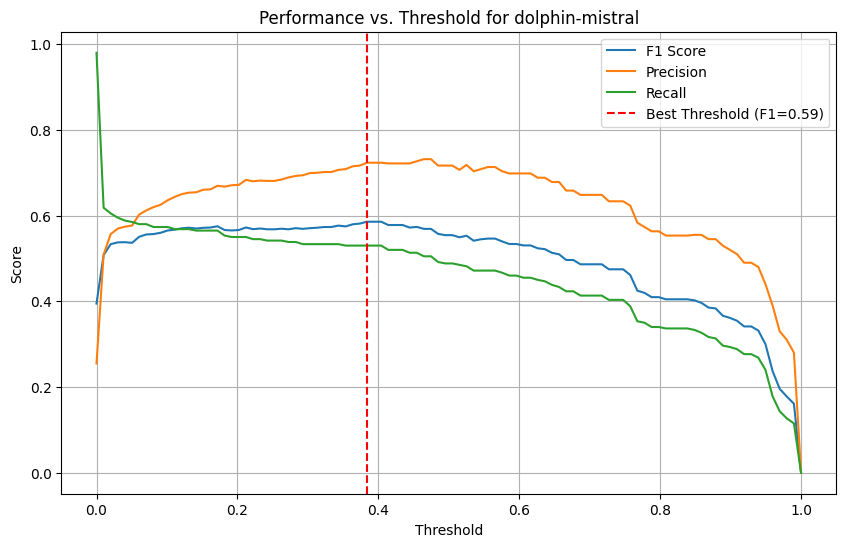

Best threshold for dolphin-mistral: 0.38 with F1=0.59


In [9]:
y_true = pd.get_dummies(df['topics'].explode()).groupby(level=0).sum()
y_true = y_true.reindex(columns=topics, fill_value=0)

ollama_model_1 = 'dolphin-mistral'
df_probs_1 = process_dataset_ollama(df, ollama_model_1)
analysis_1 = analyze_thresholds(y_true.values, df_probs_1.values)
plot_analysis(analysis_1, ollama_model_1)

### 3. Ollama Model Comparison

Processing with llama3:8b: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


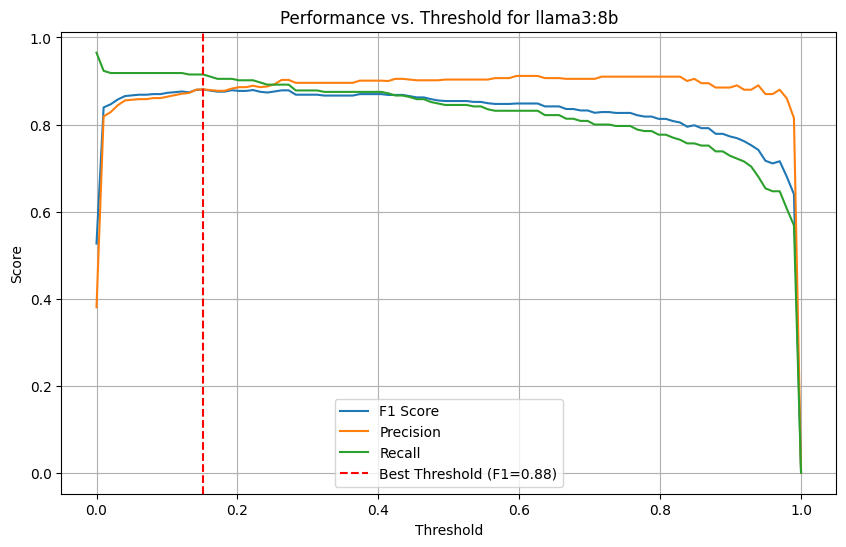

Best threshold for llama3:8b: 0.15 with F1=0.88


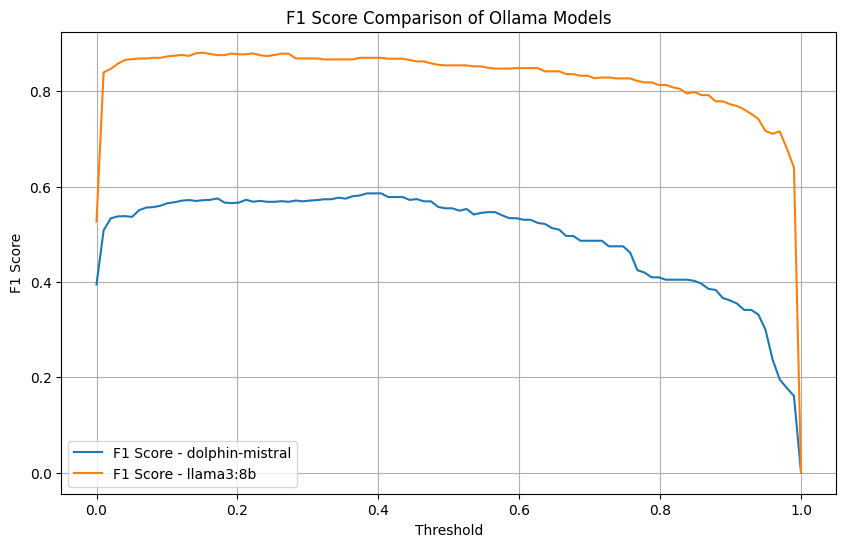

In [10]:
ollama_model_2 = 'llama3:8b'
df_probs_2 = process_dataset_ollama(df, ollama_model_2)
analysis_2 = analyze_thresholds(y_true.values, df_probs_2.values)
plot_analysis(analysis_2, ollama_model_2)

plt.figure(figsize=(10, 6))
plt.plot(analysis_1['threshold'], analysis_1['f1'], label=f'F1 Score - {ollama_model_1}')
plt.plot(analysis_2['threshold'], analysis_2['f1'], label=f'F1 Score - {ollama_model_2}')
plt.title('F1 Score Comparison of Ollama Models')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

### 4. OpenAI Log Probs Analysis

In [12]:
dotenv.load_dotenv()
client = OpenAI()
openai_model = 'gpt-4.1-mini' # OpenAI only supports logprobs for non-reasoning models

Processing with gpt-4.1-mini: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


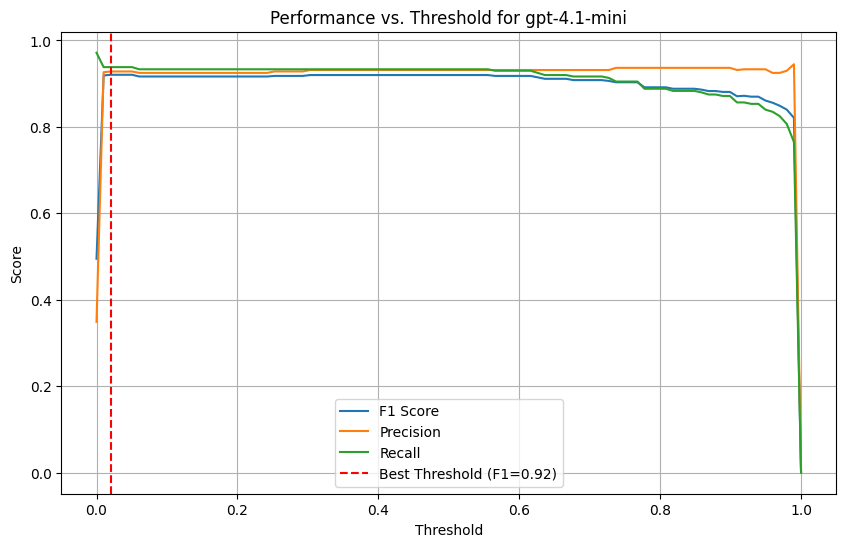

Best threshold for gpt-4.1-mini: 0.02 with F1=0.92


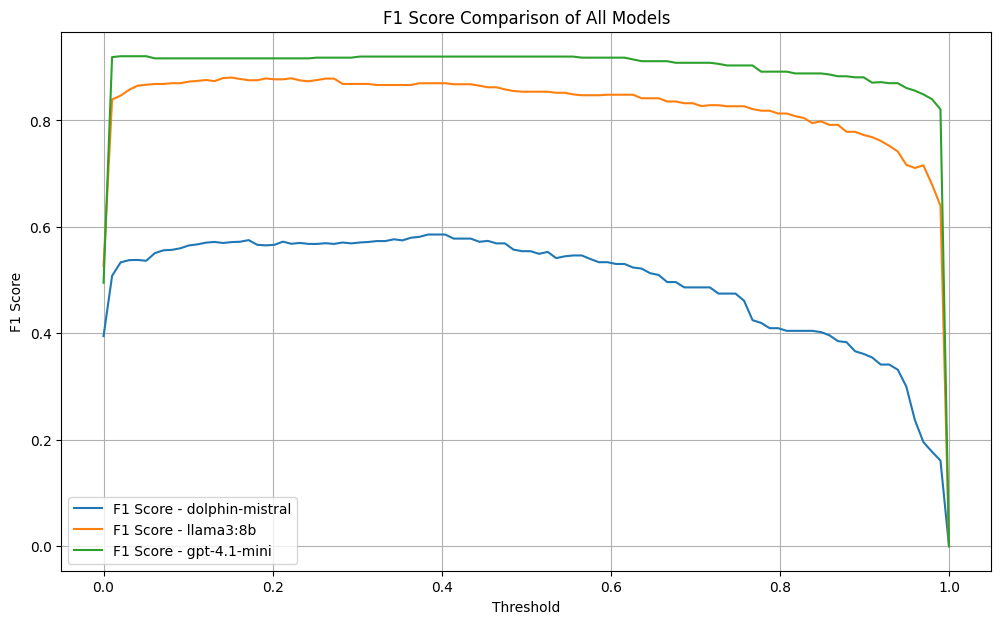

In [13]:
def get_openai_topic_probs(text, model):
    prompt = f"Given the following text, classify it into one or more of the following topics: {', '.join(topics)}. Respond with a comma-separated list of the most relevant topics only.\n\nText: {text}\n\nTopics:"
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{'role': 'user', 'content': prompt}],
            logprobs=True,
            top_logprobs=20,
            temperature=0
        )
        topic_probs = {topic: 0.0 for topic in topics}
        if response.choices[0].logprobs:
            for logprob_info in response.choices[0].logprobs.content:
                for top_logprob in logprob_info.top_logprobs:
                    token_str = top_logprob.token.strip()
                    if token_str in topics:
                        prob = math.exp(top_logprob.logprob)
                        topic_probs[token_str] = max(topic_probs[token_str], prob)
        return topic_probs
    except Exception as e:
        print(f'Error getting OpenAI probs: {e}')
        return {topic: 0.0 for topic in topics}

def process_dataset_openai(df, model):
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing with {model}'):
        probs = get_openai_topic_probs(row['text'], model=model)
        results.append(probs)
    return pd.DataFrame(results)

df_probs_openai = process_dataset_openai(df, openai_model)
analysis_openai = analyze_thresholds(y_true.values, df_probs_openai.values)
plot_analysis(analysis_openai, openai_model)

plt.figure(figsize=(12, 7))
plt.plot(analysis_1['threshold'], analysis_1['f1'], label=f'F1 Score - {ollama_model_1}')
plt.plot(analysis_2['threshold'], analysis_2['f1'], label=f'F1 Score - {ollama_model_2}')
plt.plot(analysis_openai['threshold'], analysis_openai['f1'], label=f'F1 Score - {openai_model}')
plt.title('F1 Score Comparison of All Models')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

### 5. Conclusion

This notebook demonstrated a complete workflow for multi-label topic classification using log probabilities from different LLMs. We started by generating a synthetic dataset, then used Ollama and OpenAI models to predict topics. The core of the analysis was to find the optimal probability threshold for converting logprobs into actual topic labels. By plotting precision, recall, and F1-score against various thresholds, we could visually determine the sweet spot for each model that maximizes the F1-score. The final comparison plot shows the relative performance of the models, highlighting that performance can vary significantly and that threshold tuning is a crucial step.